In [2]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [4]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tensorflow_datasets as tfds
import numpy as np

In [5]:
# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Models'

#Train, Val, and Test Folders
train_folder = "/content/drive/My Drive/Kaggle_AD_Dataset/shift_train"
val_folder = "/content/drive/My Drive/Kaggle_AD_Dataset/AD_Data_No_Aug/val"
test_folder = "/content/drive/My Drive/Kaggle_AD_Dataset/AD_Data_No_Aug/test"

In [6]:
#Setting Parameters
img_size=[299,299]
batch = 32
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [7]:
#Loading Data
data_tr = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)

data_val = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)

data_te = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)


Found 8070 files belonging to 4 classes.
Found 1537 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [8]:
#Training Data
class_names_tr = data_tr.class_names
print(class_names_tr)

for images, labels in data_tr.take(1): 
  print(images.shape, labels.shape)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
(32, 299, 299, 3) (32,)


In [9]:
#Validation Data
class_names_val = data_val.class_names
print(class_names_val)

for images, labels in data_val.take(1): 
  print(images.shape, labels.shape)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
(32, 299, 299, 3) (32,)


In [10]:
#Test Data
class_names_te = data_te.class_names
print(class_names_te)

for images, labels in data_te.take(1): 
  print(images.shape, labels.shape)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
(32, 299, 299, 3) (32,)


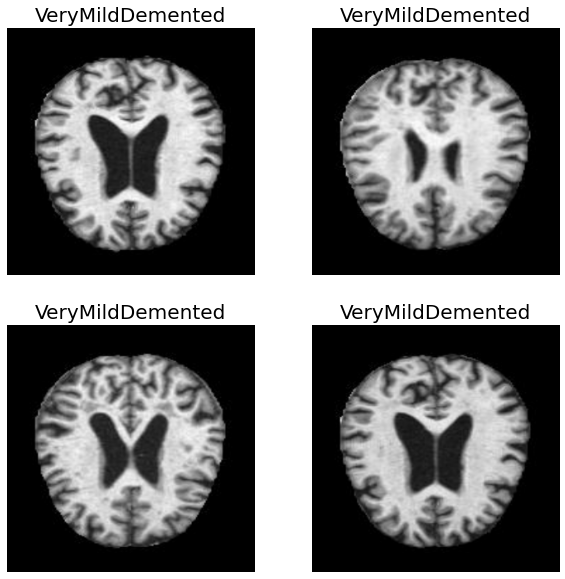

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in data_te.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_te[labels[i]])
    plt.axis("off")

In [12]:
# Set the preprocess_input of the pretrained model
global preprocess_input

preprocess_input = tf.keras.applications.xception.preprocess_input

In [13]:
#code from https://github.com/kristinslevine/teaching/blob/master/gwu/machine_learning_I/fall_2020/code/utilities/p3_deep_learning/pmlm_utilities_deep.ipynb

def preprocess_pretrain(data, label):
    """
    Preprocess the data using pretrained model

    Parameters
    ----------
    data: the data
    label: the label
    
    Returns
    ----------
    The preprocessed data using pretrained model
    """

    # Preprocess the data
    data_preprocessed = preprocess_input(data)

    return data_preprocessed, label

In [14]:
# Preprocess the training data using pretrained model
data_train = data_tr.map(preprocess_pretrain)

# Preprocess the validation data using pretrained model
data_valid = data_val.map(preprocess_pretrain)

# Preprocess the test data using pretrained model
data_test = data_te.map(preprocess_pretrain)

In [15]:
# Make directory
directory = os.path.dirname(abspath_curr)
if not os.path.exists(directory):
    os.makedirs(directory)

In [16]:
#Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.1)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

83697664/83683744 [==============================] - 0s 0us/step


In [17]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

In [18]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/shift_Xception_model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=2)

In [19]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',    
              metrics=['accuracy'])

In [20]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=10,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/10
253/253 [==============================] - 626s 2s/step - loss: 0.8303 - accuracy: 0.6276 - val_loss: 0.9064 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 2/10
253/253 [==============================] - 42s 167ms/step - loss: 0.6769 - accuracy: 0.7011 - val_loss: 0.8800 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 3/10
253/253 [==============================] - 42s 166ms/step - loss: 0.6348 - accuracy: 0.7244 - val_loss: 0.8556 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 4/10
253/253 [==============================] - 42s 167ms/step - loss: 0.6102 - accuracy: 0.7279 - val_loss: 0.8429 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 5/10
253/253 [==============================] - 42s 167ms/step - loss: 0.5836 - accuracy: 0.7408 - val_loss: 0.8365 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 6/10
253/253 [==============================] - 42s 167ms/step - loss: 0.5691 - accuracy: 0.7507 - val_loss: 0.8364 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 7/10
253/253 [==============================] - 

In [21]:
# Make directory
directory = os.path.dirname(abspath_curr + '/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

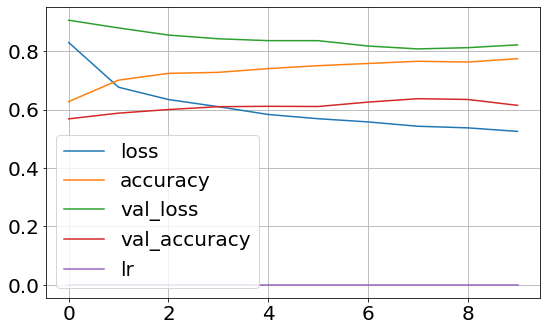

In [22]:
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/figure/shift_xcept_before_unfreezing.pdf')
plt.show()

In [23]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Unfreeze the layer
    layer.trainable = True

In [24]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=10,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/10
253/253 [==============================] - 191s 733ms/step - loss: 0.4823 - accuracy: 0.8011 - val_loss: 1.2999 - val_accuracy: 0.4496 - lr: 1.0000e-04
Epoch 2/10
253/253 [==============================] - 186s 733ms/step - loss: 0.0972 - accuracy: 0.9642 - val_loss: 0.8061 - val_accuracy: 0.7079 - lr: 1.0000e-04
Epoch 3/10
253/253 [==============================] - 186s 733ms/step - loss: 0.0557 - accuracy: 0.9788 - val_loss: 0.5498 - val_accuracy: 0.8269 - lr: 1.0000e-04
Epoch 4/10
253/253 [==============================] - 186s 733ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.4358 - val_accuracy: 0.8608 - lr: 1.0000e-04
Epoch 5/10
253/253 [==============================] - 185s 728ms/step - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.4588 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 6/10
253/253 [==============================] - 185s 729ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.8869 - val_accuracy: 0.7944 - lr: 1.0000e-04
Epoch 7/10
253/253 [==

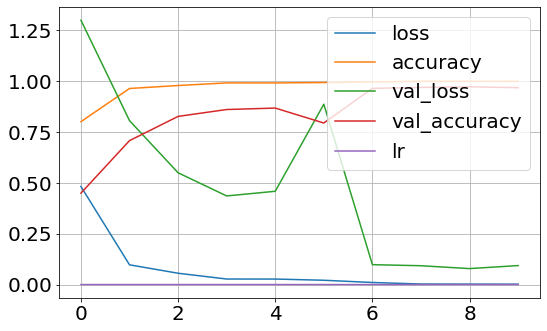

In [26]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/figure/shift_xcept_after_unfreezing.pdf')
plt.show()

In [27]:
import os
import cv2
#DataFolders
data_folder = "/content/drive/My Drive/Kaggle_AD_Dataset/AD_Data_No_Aug/test"

data_mild = data_folder + "/MildDemented/"
data_mod = data_folder + "/ModerateDemented/"
data_non = data_folder + "/NonDemented/"
data_very = data_folder + "/VeryMildDemented/"

print('Number of MildDemented:', len(os.listdir(data_mild)))
print('Number of ModerateDemented:', len(os.listdir(data_mod)))
print('Number of NonDemented:', len(os.listdir(data_non)))
print('Number of VeryMildDemented:', len(os.listdir(data_very)))

Number of MildDemented: 179
Number of ModerateDemented: 12
Number of NonDemented: 640
Number of VeryMildDemented: 448


In [28]:
RESIZE_TO = 299

x, y = [], []
for path in [f for f in os.listdir(data_mild) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mild + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mild")
for path in [f for f in os.listdir(data_mod) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_mod + path), (RESIZE_TO, RESIZE_TO)))
    y.append("mod")
for path in [f for f in os.listdir(data_non) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_non + path), (RESIZE_TO, RESIZE_TO)))
    y.append("non")
for path in [f for f in os.listdir(data_very) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_very + path), (RESIZE_TO, RESIZE_TO)))
    y.append("very")

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["mild", "mod", "non", "very"])
y_test = le.transform(y)

In [30]:
x_test, y_test = np.array(x), np.array(y_test)
x_test = tf.keras.applications.xception.preprocess_input(x_test, data_format = None)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)

In [31]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/shift_Xception_model.h5')

In [32]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels

In [33]:
def get_images_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[0], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels

In [34]:
x_test = get_images_from_tfdataset(test_dataset, batched=False)
y_test = get_labels_from_tfdataset(test_dataset, batched = False)

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["mild", "mod", "non", "very"]

y_pred_xcept = model.predict(x_test)
pred_xcept = np.argmax(y_pred_xcept, axis=1)
print(classification_report(y_test, pred_xcept, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y_test, pred_xcept) * 100)
print("\n")

              precision    recall  f1-score   support

        mild       0.80      0.50      0.62       179
         mod       0.56      0.83      0.67        12
         non       0.84      0.69      0.76       640
        very       0.61      0.84      0.71       448

    accuracy                           0.72      1279
   macro avg       0.70      0.72      0.69      1279
weighted avg       0.75      0.72      0.72      1279

Accuracy :  72.08756841282252


